In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import astropy.coordinates as coord
from astropy.time import Time
import astropy.units as u
import pandas as pd
from mpmath import cot
from matplotlib.colors import Normalize as Normalize
import matplotlib.patches as patches

# Define the time, location, and turbine specs

In [2]:
nt = 48*2+1
times   = pd.date_range('2019-08-15', periods=nt, freq='30min')
loc     = coord.EarthLocation(lon=0.1 * u.deg,
                              lat=42.0 * u.deg)
azi_ang = np.zeros((nt))
elv_ang = np.zeros((nt))
shadow_length_tower     = np.zeros((nt))
shadow_length_rotor_top = np.zeros((nt))
shadow_length_rotor_bot = np.zeros((nt))

tower_height = 70.0 # meters
tower_width  = 4.0 # meters
rotor_rad    = 40.0 # meters

# Save directory

In [3]:
savedir = '/home/phawbeck/ShadowCast/'
showAnim = True

# Loop over all times and calculate elevation angle

In [4]:
for tt,time in enumerate(times):
    sun_time = Time(time) #UTC time
 
    sunpos = coord.AltAz(obstime=sun_time, location=loc)
    #zenith = coord.get_sun(sun_time).transform_to(sunpos).zen
    alt    = coord.get_sun(sun_time).transform_to(sunpos).alt
    azi    = coord.get_sun(sun_time).transform_to(sunpos).az
    elv_ang[tt] = alt.degree
    azi_ang[tt] = azi.degree
    #zen_ang[tt] = zenith.degree

# Calculate the shadow length and angle
https://rechneronline.de/sehwinkel/shadow-casting.php

#### (From Wikipedia) 
However, despite tradition, the most commonly accepted convention for analyzing solar irradiation, e.g. for solar energy applications, is clockwise from due north, so east is 90°, south is 180°, and west is 270°.

In [5]:
for tt in range(0,nt):
    shadow_length_tower[tt]     = tower_height*cot(np.radians(elv_ang[tt]))
    shadow_length_rotor_top[tt] = (tower_height+rotor_rad)*cot(np.radians(elv_ang[tt]))
    shadow_length_rotor_bot[tt] = (tower_height-rotor_rad)*cot(np.radians(elv_ang[tt]))
shadow_length_tower[elv_ang <=0.0] = np.nan
shadow_length_rotor_top[elv_ang <=0.0] = np.nan
shadow_length_rotor_bot[elv_ang <=0.0] = np.nan
shadow_ang = azi_ang - 180.0
shadow_ang[elv_ang <= 0.0] = np.nan
shadow_ang[shadow_ang < 0.0] += 360.0

/home/phawbeck/.conda-envs/pyhawbeck2/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.


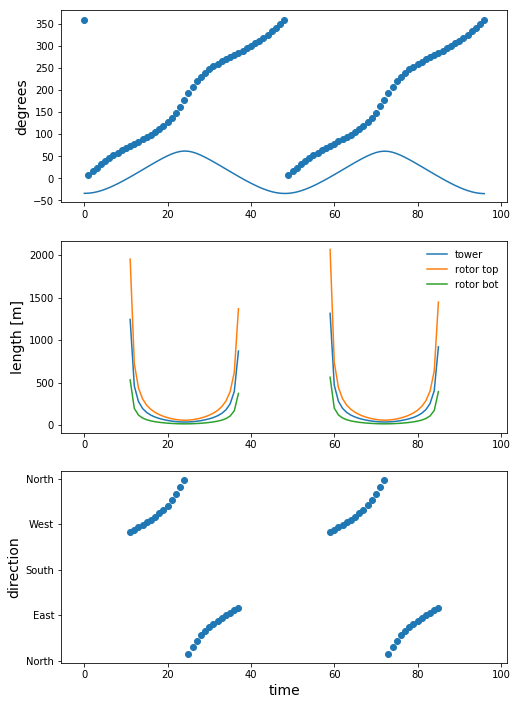

In [6]:
#print np.nanmax(elv_ang)
#print np.nanmin(shadow_length)
plt.figure(figsize=(8,12))
solarplt = plt.subplot(311)
plt.plot(range(0,nt),elv_ang)
plt.plot(x=0.0,c='k',alpha=0.5,ls=':')
plt.scatter(range(0,nt),azi_ang)
plt.ylabel('degrees',size=14)
plt.subplot(312,sharex=solarplt)
plt.plot(shadow_length_tower,label='tower')
plt.plot(shadow_length_rotor_top,label='rotor top')
plt.plot(shadow_length_rotor_bot,label='rotor bot')
plt.legend(frameon=False)
plt.ylabel('length [m]',size=14)
plt.subplot(313,sharex=solarplt)
plt.scatter(range(0,nt),shadow_ang)
plt.xlabel('time',size=14)
plt.ylabel('direction',size=14)
plt.yticks([0.0,90.0,180.0,270.0,360.0], ['North','East','South','West','North'])
plt.show()

# Generate a mesh assuming tower in center

In [7]:
dx,dy = 1.0,1.0
lx,ly = 1000.0, 1000.0
x = np.arange(0,lx+0.1,dx) - lx/2.0
xc = 0.5*(x[1:] + x[:-1])
y = np.arange(0,ly+0.1,dy) - ly/2.0
yc = 0.5*(y[1:] + y[:-1])
xy,yx = np.meshgrid(x,y)
xyc, yxc = np.meshgrid(xc,yc)
surface = np.zeros((np.shape(xyc)[0],np.shape(xyc)[1],nt))

distance = np.sqrt(xyc**2 + yxc**2)
angle            = np.degrees(np.arctan(xyc/yxc))
angle[yxc<0.0]   = angle[yxc<0.0] + 180.0
angle[angle<0.0] = angle[angle<0.0] + 360.0

# Calculate turbine shadow on grid

Find cells that are between these and add a buffer for cells that are close?

In [8]:
for toi in range(0,nt):
    # Make "sunlight" a function of sun elevation angle
    surface[:,:,toi] = elv_ang[toi]
    D     = shadow_length_tower[toi]
    theta = np.radians(shadow_ang[toi])
    mask  = np.ones(np.shape(xyc))
    plt.subplot(aspect='equal')
    
    htw = tower_width/2.0
    # find the left and right edges of the tower shadow by adding/subtracting 90 degrees from the shadow angle
    tower_left_xs, tower_left_ys = htw*np.sin(np.radians(shadow_ang[toi]-90.0)), htw*np.cos(np.radians(shadow_ang[toi]-90.0))
    tower_rght_xs, tower_rght_ys = htw*np.sin(np.radians(shadow_ang[toi]+90.0)), htw*np.cos(np.radians(shadow_ang[toi]+90.0))
    tower_left_xe, tower_left_ye = D*np.sin(theta)+tower_left_xs, D*np.cos(theta)+tower_left_ys
    tower_rght_xe, tower_rght_ye = D*np.sin(theta)+tower_rght_xs, D*np.cos(theta)+tower_rght_ys
    # Find the slopes & intercepts of these lines to find the cells that are between the two
    tower_left_slope = (tower_left_ys-tower_left_ye) / (tower_left_xs-tower_left_xe)
    tower_rght_slope = (tower_rght_ys-tower_rght_ye) / (tower_rght_xs-tower_rght_xe)
    tower_left_int   = tower_left_ys - tower_left_slope*tower_left_xs
    tower_rght_int   = tower_rght_ys - tower_rght_slope*tower_rght_xs
    tower_axis_slope = (tower_left_ys-tower_rght_ys) / (tower_left_xs-tower_rght_xs)
    # Make is so that the angle is 0 in the direction of the shadow... remove 180 > A > 270
    shadow_angle = angle-shadow_ang[toi]
    shadow_angle[shadow_angle<0.0] += 360.0
    # Find points between the two lines...
    mask[((yxc>=tower_left_slope*xyc+tower_left_int) & (yxc<=tower_rght_slope*xyc+tower_rght_int)) | 
         ((yxc<=tower_left_slope*xyc+tower_left_int) & (yxc>=tower_rght_slope*xyc+tower_rght_int))] = 0.0
    # Find points that are less than the shadow distance
    mask[distance>shadow_length_tower[toi]] = 1.0
    # Find points in the direction of the shadow
    mask[(shadow_angle>90.0) & (shadow_angle<270.0)] = 1.0
    
    # Define the ellipse!
    g_ell_center = (D*np.sin(theta), D*np.cos(theta))
    g_ell_height = rotor_rad
    g_ell_width  = shadow_length_rotor_top[toi] - shadow_length_rotor_bot[toi]
    ell_angle    = np.degrees(np.arctan2(D*np.cos(theta), D*np.sin(theta)))
    # Get the angles of the axes
    cos_angle = np.cos(np.radians(180.-ell_angle))
    sin_angle = np.sin(np.radians(180.-ell_angle))
    # Find the distance of each gridpoint from the ellipse
    exc = xyc - g_ell_center[0]
    eyc = yxc - g_ell_center[1]
    exct = exc * cos_angle - eyc * sin_angle
    eyct = exc * sin_angle + eyc * cos_angle 
    # Get the radial distance away from ellipse: cutoff at r = 1
    rad_cc = (exct**2/(g_ell_width/2.)**2) + (eyct**2/(g_ell_height/2.)**2)

    g_ellipse = patches.Ellipse(g_ell_center, g_ell_width, g_ell_height, angle=ell_angle, 
                                fill=False, edgecolor='green', linewidth=2)
    mask[rad_cc<=1.0] = mask[rad_cc<=1.0]*0.8   
    

    surface[:,:,toi] = surface[:,:,toi]*mask
    plt.pcolormesh(xy,yx,surface[:,:,toi],norm=Normalize(0,60))
    plt.colorbar()
    plt.plot([0,0],[0,tower_height/2.0],c='k')
    plt.scatter(0,tower_height/2.0,color='k',marker='2',s=300)
    #plt.scatter(D*np.sin(theta), D*np.cos(theta),c='k')
    plt.xlim((-200,200))
    plt.ylim((-200,200))
    plt.title(times[toi])

    if showAnim: 
        pltstr  = 'shadow'
        #savestr = '{}img/anim/{}_{}.png'.format(savedir,pltstr,str(times[toi]).replace(' ','_').replace(':',''))
        savestr = '{}img/anim/{}_{:05d}.png'.format(savedir,pltstr,toi)
        plt.savefig(savestr)
        plt.clf()
    else:
        plt.show()

/home/phawbeck/.conda-envs/pyhawbeck2/lib/python2.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in less
/home/phawbeck/.conda-envs/pyhawbeck2/lib/python2.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater_equal
/home/phawbeck/.conda-envs/pyhawbeck2/lib/python2.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in less_equal
/home/phawbeck/.conda-envs/pyhawbeck2/lib/python2.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in greater
/home/phawbeck/.conda-envs/pyhawbeck2/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in greater
/home/phawbeck/.conda-envs/pyhawbeck2/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in less
/home/phawbeck/.conda-envs/pyhawbeck2/lib/python2.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encou

<Figure size 432x288 with 0 Axes>

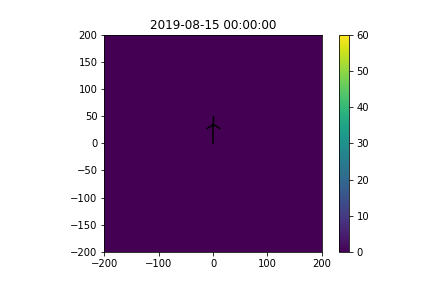

In [9]:
if showAnim:
    import glob
    import os
    from IPython.display import Image

    gif_name = '{}'.format(pltstr)
    file_list = glob.glob('{}img/anim/*.png'.format(savedir)) # Get all the pngs in the directory
    list.sort(file_list, key=lambda x: int(x.split('_')[1].split('.png')[0])) # Sort the images

    with open('{}image_list.txt'.format(savedir), 'w') as file:
        for item in file_list:
            file.write("%s\n" % item)

    os.system('convert -delay 10 @{}image_list.txt {}img/{}.gif'.format(savedir,savedir,gif_name))
    gifstr = '{}img/{}.gif'.format(savedir,pltstr)
    with open(gifstr,'rb') as gfile:
        display(Image(gfile.read()))